## 0. Content

* [1. Loading and Visualizing data](#section1)
* [2. Solving SVM Dual Problem](#section2)
    * [2.1. Examine the result](#section2.1)
    * [2.2. Solving the roots of SVM Primal Problem](#section2.2)
    * [2.3. Plotting the result](#section2.3)
* [3. Solving SVM Primal Problem](#section3)
* [4. Solving SVM with sklearn](#section4)
* [5. References](#section5)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<a id='section1'></a>
## 1. Loading and Visualizing data

In [2]:
# Just a simple 2D data
data = np.loadtxt('../data/data7.txt', delimiter = ',')

m = data.shape[0]  # Number of training examples

y = data[:, np.newaxis, 2]

X = data[:, 0:2]
X0 = X[np.where(y == 0)[0], :]  # Class 0 (not feature!)
X1 = X[np.where(y == 1)[0], :]  # Class 1

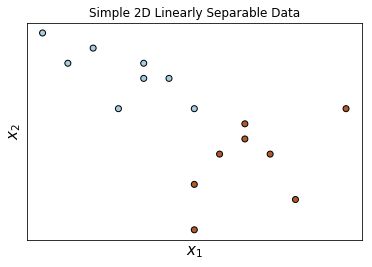

In [3]:
plt.figure(1)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Paired, edgecolors = 'k')
plt.xlabel('$x_1$', fontsize = 15)
plt.ylabel('$x_2$', fontsize = 15)
plt.xticks(())
plt.yticks(())
plt.title('Simple 2D Linearly Separable Data')
plt.show()

<a id='section2'></a>
## 2. Solving SVM Dual Problem

SVM Dual Problem is a Quadratic Programming, we can solve this with [CVXOPT](http://cvxopt.org/) (Python Software For Convex Optimization):

<a href="https://www.codecogs.com/eqnedit.php?latex=(\lambda)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\lambda^{T}&space;P&space;\lambda&space;&plus;&space;(-1)^{T}\lambda&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;\left\{\begin{matrix}&space;y^{T}\lambda&space;=&space;0&space;\\&space;\lambda&space;\geq&space;0&space;\end{matrix}\right." target="_blank"><img src="https://latex.codecogs.com/gif.latex?(\lambda)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\lambda^{T}&space;P&space;\lambda&space;&plus;&space;(-1)^{T}\lambda&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;\left\{\begin{matrix}&space;y^{T}\lambda&space;=&space;0&space;\\&space;\lambda&space;\geq&space;0&space;\end{matrix}\right." title="(\lambda) = argmin ~ \frac{1}{2} \lambda^{T} P \lambda + (-1)^{T}\lambda \newline \newline ~\hspace{45pt} subject ~ to: \left\{\begin{matrix} y^{T}\lambda = 0 \\ \lambda \geq 0 \end{matrix}\right." /></a>

The name of the matrices is according to the official documentation of CVXOPT on Quadratic Programming: [link](http://cvxopt.org/userguide/coneprog.html#quadratic-programming).

In [4]:
from cvxopt import matrix, solvers

In [5]:
# Map 0 to -1
y[np.where(y == 0)[0], 0] = -1

# Build the Quadratic Coefficient Matrix P
V = np.concatenate((-X0, X1), axis = 0)
P = matrix(V.dot(V.T))

q = matrix(-np.ones((m, 1)))
# Matrices for the equality constraint
A = matrix(np.reshape(y.T, (1, m)))
b = matrix(np.zeros((1, 1)))
# Matrices for the unequality constraint (lambda >= 0)
G = matrix(-np.eye(m))
h = matrix(np.zeros((m, 1)))  # G*lambda <= h; so with given G, h: lambda >= 0

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)  # Solve the Quadratic Programming

<a id='section2.1'></a>
### 2.1. Examine the result

In [6]:
l = np.array(sol['x'])
print('lambda = ')
print(l.T)

lambda = 
[[  1.59999998e+00   1.93985296e-09   1.29330228e-09   6.46651145e-10
    1.29343877e-09   1.10851193e-09   5.96927966e-10   4.56465238e-10
    1.10871283e-09   1.59950601e+00   8.62142125e-10   1.93985296e-09
    3.39909447e-04   7.75823699e-09   1.54049256e-04   2.58511819e-09]]


We can observe there are 4 lambda values which aren't equal to 0, hence there are 4 support vectors.

<a id='section2.2'></a>
### 2.2. Solving the roots of SVM Primal Problem

In [7]:
epsilon = 1e-6  # Need this since we're working on float numbers
S = np.where(l > epsilon)[0]  # Support set: a set of support vectors

VS = V[S, :]
XS = X[S, :]
yS = y[S, :]
lS = l[S]

# Calculate w and b
w = lS.T.dot(VS)
b = np.mean(yS.T - w.dot(XS.T))

print('w = ', w)
print('b = ', b)

w =  [[ 1.59967597 -0.800648  ]]
b =  1.39971648323


### 2.3. Plotting the result

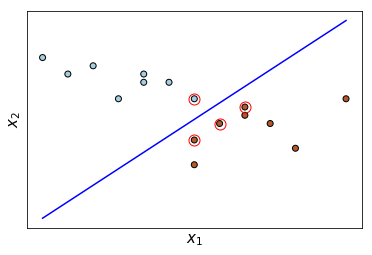

In [8]:
plt.figure(2)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Paired, edgecolors = 'k')

# Plot the separable line
x1_min, x1_max = np.min(X[:, 0]), np.max(X[:, 0])
x1 = np.linspace(x1_min, x1_max, endpoint = True)
slope = -w[0][0] / w[0][1]
intercept = -b / w[0][1]
x2 = slope * x1 + intercept
plt.plot(x1, x2, color = 'blue')

# Circle around 4 support vectors
plt.plot(XS[:, 0], XS[:, 1], 'ro', fillstyle = 'none', markersize = 11)

plt.xticks(())
plt.yticks(())
plt.xlabel('$x_1$', fontsize = 15)
plt.ylabel('$x_2$', fontsize = 15)

plt.show()

## 3. Solving SVM Primal Problem

The SVM Primal Problem is maximizing the margin for the separable line:

<a href="https://www.codecogs.com/eqnedit.php?latex=(w,&space;b)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\left&space;\|&space;w&space;\right&space;\|^{2}_{2}&space;=&space;argmin&space;\frac{1}{2}&space;w^{T}Iw&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;1&space;-&space;y_{n}(w^{T}x_{n}&plus;b)&space;\leq&space;0" target="_blank"><img src="https://latex.codecogs.com/gif.latex?(w,&space;b)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\left&space;\|&space;w&space;\right&space;\|^{2}_{2}&space;=&space;argmin&space;\frac{1}{2}&space;w^{T}Iw&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;1&space;-&space;y_{n}(w^{T}x_{n}&plus;b)&space;\leq&space;0" title="(w, b) = argmin ~ \frac{1}{2} \left \| w \right \|^{2}_{2} = argmin \frac{1}{2} w^{T}Iw \newline \newline ~\hspace{45pt} subject ~ to: 1 - y_{n}(w^{T}x_{n}+b) \leq 0" /></a>

This is also a Quadractic Programming and we can use CVXOPT again to solve it.

## 4. Solving SVM with sklearn

In [9]:
from sklearn.svm import SVC

In [10]:
y = y.reshape((m,))
clf = SVC(kernel = 'linear', C = 1e6)  # With large C, the solver will focus on
                                       # maximizing the margin of separable line
                                       # (Since the data is linearly separable, there's no error 
                                       # and we don't care of it)
            
clf.fit(X, y)

w = clf.coef_
b = clf.intercept_
print('w = ', w)
print('b = ', b)

w =  [[ 1.6 -0.8]]
b =  [ 1.4]


The obtained result is the same as solving the dual problem with CVXOPT.

## 5. References

[[1] CVXOPT](http://cvxopt.org/)

[[2] machinelearningcoban.com](https://machinelearningcoban.com/)
